In [40]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('corpus')

# Configurar visualización
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\mathi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading corpus: Package 'corpus' not found in index


In [41]:
#Cargamos los csv EDA
subreddit_data = pd.read_csv('../data/subreddit_data.csv')
posts_data = pd.read_csv('../data/posts_data.csv')
subreddit_data = subreddit_data.fillna("")
posts_data = posts_data.fillna("")

In [42]:
class RedditTextProcessor:
    def __init__(self):
        # Inicializar el lematizador
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.columns_to_process = ["titlePost", "tittleSubreddit", "descriptionReddit"]

    def preprocess_text(self, text):
        # Tokenización
        text = str(text)
        tokens = word_tokenize(text.lower())
        # Lematización y filtrado de stopwords
        tokens = [
            self.lemmatizer.lemmatize(token) for token in tokens 
            if token.isalpha() and token not in self.stop_words
        ]
        # Se devuelve una cadena y no una lista de tokens para los modelos de aprendizaje
        return " ".join(tokens)
    
    def process_dataframe(self, df):
        for column in df.columns:
            if df[column].dtype == object and column  in self.columns_to_process:
                df[column] = df[column].apply(self.preprocess_text)
        return df

In [45]:
textProcessor = RedditTextProcessor()
processed_subreddit = textProcessor.process_dataframe(subreddit_data)
processed_posts = textProcessor.process_dataframe(posts_data)


processed_text = pd.DataFrame({
    'combined_text': processed_subreddit["tittleSubreddit"] + " " + 
                     processed_subreddit['descriptionReddit'] + " " + 
                     processed_posts['titlePost']
})
processed_text['combined_text'] = processed_text['combined_text'].fillna("")

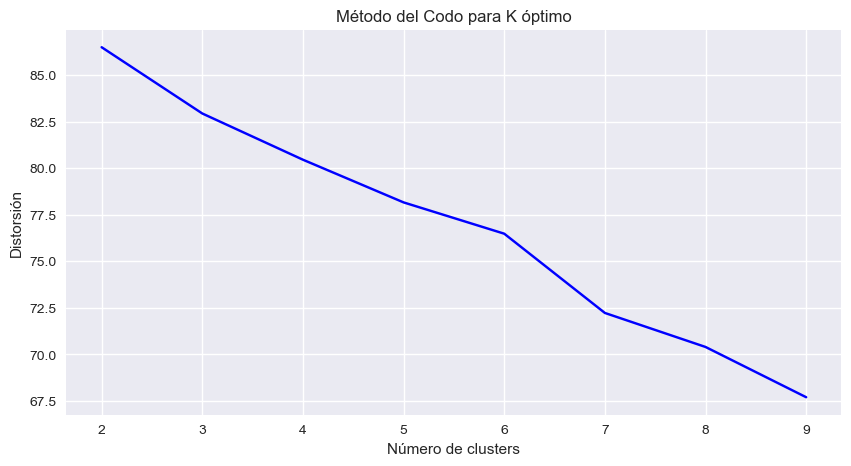

In [49]:
class RedditClustering:
    def __init__(self, corpus):
        #Transformacion de texto a valor numerica para procesar datos
        self.vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english')
        self.tfidf_matrix = self.vectorizer.fit_transform(corpus)
    
    def get_k_values(self):
        distortions = []
        K = range(2, 10)
        for k in K:
            kmeans_model = KMeans(n_clusters=k, random_state=42)
            kmeans_model.fit(self.tfidf_matrix)
            distortions.append(kmeans_model.inertia_)

        # Visualización del método del codo
        plt.figure(figsize=(10, 5))
        plt.plot(K, distortions, 'bx-')
        plt.xlabel('Número de clusters')
        plt.ylabel('Distorsión')
        plt.title('Método del Codo para K óptimo')
        plt.show()

    def apply_kmeans(self, k, df):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(self.tfidf_matrix)
        clusters = kmeans.labels_
        df['Cluster'] = clusters
        return df


clustering = RedditClustering(processed_text['combined_text'])
clustering.get_k_values()
processed_text = clustering.apply_kmeans(5, processed_text)

,combined_text,Cluster
0,home price range house like,2
1,askreddit place ask answer question door garage,4
2,nostupidquestions ask away disclaimer anonymou...,4
3,community baldur gate iii video game larian s...,1
4,facepalm please sir inspector said termite dam...,2
...,...,...
29995,,0
29996,,0
29997,,0
29998,,0
